In [ ]:
# Reference:
#     gpflow: https://gpflow.readthedocs.io/en/master/notebooks/advanced/gps_for_big_data.html
#             https://github.com/GPflow/GPflow/blob/develop/gpflow/models/sgpr.py#L263
#     julia:  https://github.com/STOR-i/GaussianProcesses.jl/blob/master/src/sparse/fully_indep_train_conditional.jl
#     ladax:  https://github.com/danieljtait/ladax
#

import sys
sys.path.append('../kernel')

import numpy as np
import numpy.random as npr
np.set_printoptions(precision=3,suppress=True)

import jax
from jax import device_put, random
import jax.numpy as np
import jax.numpy.linalg as linalg
from jax.scipy.linalg import cho_solve, solve_triangular

from typing import Any, Callable, Sequence, Optional, Tuple
import flax
from flax import linen as nn
from flax import optim

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import torch
print(torch.cuda.is_available(), jax.devices())


import matplotlib.pyplot as plt
import matplotlib as mpl
# https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 25
mpl.rcParams['font.family'] = 'Times New Roman'
cmap = plt.cm.get_cmap('bwr')

from tabulate import tabulate

import sys
sys.path.append('../kernel')
from jaxkern import (cov_se, cov_rq, cov_pe, LookupKernel, normalize_K, mtgp_k)

from plt_utils import plt_savefig, plt_scaled_colobar_ax
from gp import gp_regression_chol, run_sgd
from gpax import is_psd, cholesky_jitter, BijectiveSoftplus, BijectiveFillTril, BijectiveExp
from gpax import log_func_default, log_func_simple, flax_run_optim
from gpax import CovSE, LikNormal, GPR, GPRFITC, VFE
from gpax import kl_mvn, kl_mvn_tril, kl_mvn_tril_zero_mean_prior



In [ ]:

## Parameters 

xlim = (-1, 1)
ylim = (-2, 2)
n_train = 200
n_test = 200
σn = .5
logsn = np.log(σn)
lr = .01
num_steps = 20


## Data

def f_gen(x):
    return np.sin(x * 3 * 3.14) + \
           0.3 * np.cos(x * 9 * 3.14) + \
           0.5 * np.sin(x * 7 * 3.14)

## Plotting

key = jax.random.PRNGKey(0)
npr.seed(0)
X_train = np.expand_dims(npr.uniform(xlim[0], xlim[1], size=n_train), 1)
y_train = f_gen(X_train) + σn * npr.rand(n_train, 1)
data = (X_train, y_train)
X_test  = np.expand_dims(np.linspace(*xlim, n_test), 1)

X_train = device_put(X_train)
y_train = device_put(y_train)
X_test = device_put(X_test)

print(X_train.shape, y_train.shape)


fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(X_train, y_train, 'x', alpha=1)
ax.grid()
ax.set_ylim(ylim)

In [ ]:
m = 50
X, y = data

qμ = np.zeros((m,1))
qL = BijectiveFillTril.forward(np.ones((((1+m)*m)//2, 1)))

μ0 = qμ
Σ0 = qL@qL.T
μ1 = random.normal(key,(m,1))
Σ1 = BijectiveFillTril.forward(random.normal(key,(((1+m)*m)//2, 1)))
Σ1 = Σ1@Σ1.T + .1*np.eye(m)

    


L1 = cholesky_jitter(Σ1)
elbo_kl = kl_mvn_tril_zero_mean_prior(qμ, qL, L1)


import numpy

numpy.polynomial.hermite.hermgauss


In [ ]:





class LikNormal(nn.Module):
    
    def setup(self):
        transform = BijectiveSoftplus()
        init_fn = lambda k, s: transform.reverse(np.array([1.]))
        self.σ2 = transform.forward(self.param('σ2', init_fn, (1,)))
    
    






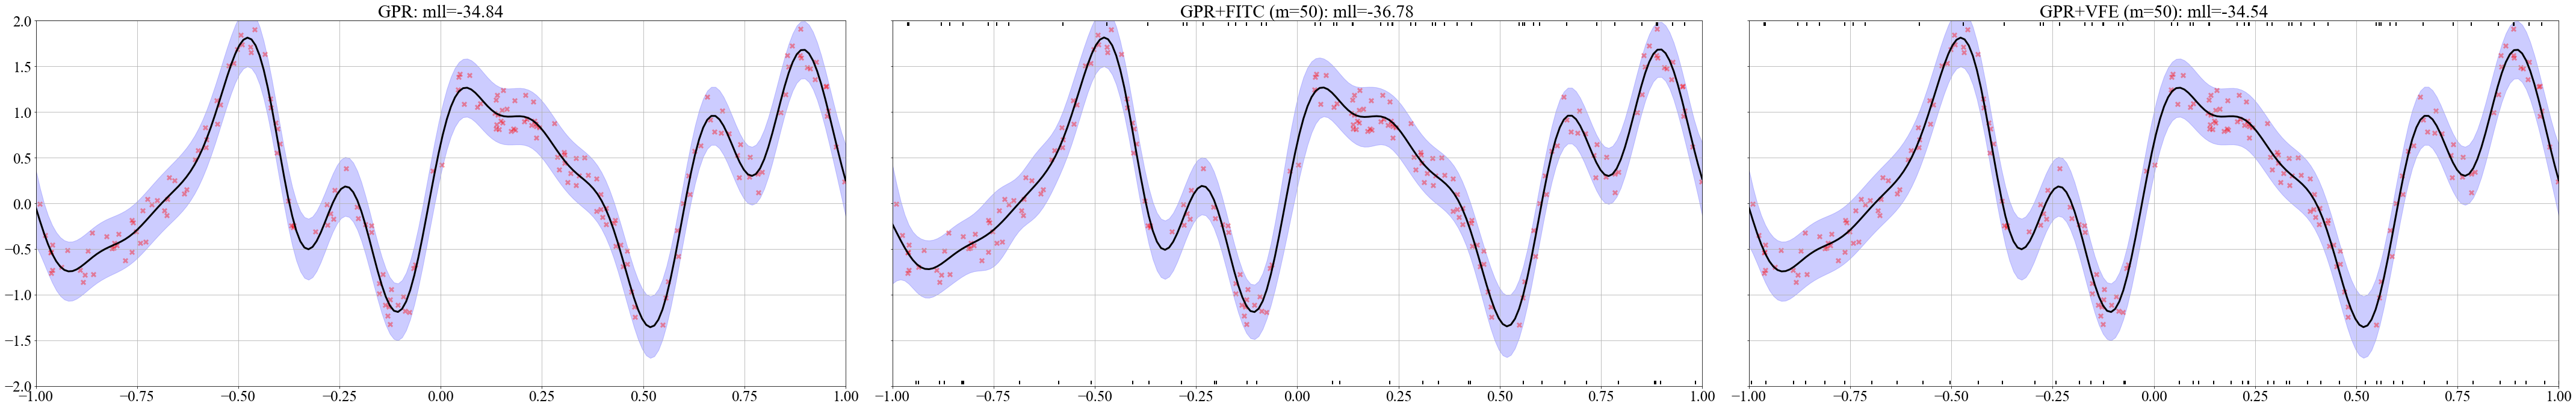

In [4]:
optimizer_kwargs = {'learning_rate': .001}
num_steps = 400
n_inducing = 50


fig, axs = plt.subplots(1, 3, figsize=(20*3,10), sharey=True)

def get_model(i):
    if i == 0:
        return 'GPR', GPR(data)
    if i == 1:
        return f'GPR+FITC (m={n_inducing})', GPRFITC(data, n_inducing)
    if i == 2:
        return f'GPR+VFE (m={n_inducing})', VFE(data, n_inducing)
    
    
def log_func(i, f, params):
    if i%20==0:
        print(f'[{i:3}]\tLoss={f(params):.3f}\t'
              f'σn={np.exp(params["params"]["logσn"][0]):.3f}\t'
              f'kℓ={np.exp(params["params"]["k"]["logℓ"][0]):.3f}\t'
              f'kσ={np.exp(params["params"]["k"]["logσ"][0]):.3f}\t'
              + (f'Xu[:5]={params["params"]["Xu"][:5,0]}' if 'Xu' in params["params"] else ''))

for i in range(3):
    name, model = get_model(i)
    params = model.get_init_params(key)
    if i != 0:
        Xu_initial = params['params']['Xu']
    nmll = lambda params: -model.apply(params, method=model.mll)
    nmll = jax.jit(nmll)
    params = flax_run_optim(nmll, params, num_steps=num_steps, log_func=log_func_default,
                            optimizer_kwargs=optimizer_kwargs)
    
    mll = model.apply(params, method=model.mll)
    μ, Σ = model.apply(params, X_test, method=model.pred_y)
    std = np.expand_dims(np.sqrt(np.diag(Σ)), 1)

    ax = axs[i]
    ax.plot(X_test, μ, color='k')
    ax.fill_between(X_test.squeeze(), (μ-2*std).squeeze(), (μ+2*std).squeeze(), alpha=.2, color=cmap(0))
    ax.scatter(X_train, y_train, marker='x', color='r', s=50, alpha=.4)
    if i != 0:
        Xu = params['params']['Xu']
        ax.plot(Xu_initial, np.ones_like(Xu)*ylim[1]-.04, "k|", mew=2, label="Inducing locations")
        ax.plot(Xu, np.ones_like(Xu)*ylim[0]+.04, "k|", mew=2, label="Inducing locations")
    ax.grid()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(f'{name}: mll={-mll:.2f}')
    

fig.tight_layout()
# plt_savefig(fig, 'summary/assets/plt_apx_comparison.png')
    